### 딥러닝 테스트

In [1]:
import pandas as pd

df = pd.read_csv("/home/kkyu/amr_ws/DL/IoT_Project/실내오염지수분석.csv")
df

/tmp/ipykernel_29415/2635104805.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,date,temp,humidity,dust,pollution,co2
0,2013-01-01,20,84,13,129,72.076
1,2013-01-02,21,92,9,148,64.442
2,2013-01-03,20,87,6,159,64.084
3,2013-01-04,20,71,4,181,60.842
4,2013-01-05,20,86,5,138,61.798
...,...,...,...,...,...,...
1455,2016-12-28,27,68,15,227,74.000
1456,2016-12-29,26,87,14,224,125.000
1457,2016-12-30,25,89,13,187,93.000
1458,2016-12-31,24,87,15,150,89.000


In [2]:
print(df.isnull().sum())

date         0
temp         0
humidity     0
dust         0
pollution    0
co2          0
dtype: int64


### Forcasting air pollution with LSTM

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

2024-03-07 15:00:56.848113: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 15:00:57.055494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 15:00:57.055675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 15:00:57.105142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 15:00:57.172450: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# 입력 데이터와 타겟 데이터 분할
x = df[['temp', 'humidity', 'dust', 'co2']].values
y = df['pollution'].values

# 데이터 정규화 (Normalization)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [5]:
# 시계열 데이터를 생성하는 함수 정의
def create_sequences(x, y, time_steps=10):
    X, Y = [], []
    for i in range(len(x) - time_steps):
        xi = x[i:(i + time_steps)]
        yi = y[i + time_steps]
        X.append(xi)
        Y.append(yi)
    return np.array(X), np.array(Y)

# 시계열 데이터 생성
time_steps = 10
X, Y = create_sequences(x_scaled, y_scaled, time_steps)

# 데이터셋을 훈련 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [7]:
model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

2024-03-07 15:00:59.130802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 15:00:59.234969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 15:00:59.235210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            17664     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 10, 32)            0         
                                                                 
 dense (Dense)               (None, 10, 1)             33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [9]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30


2024-03-07 15:01:01.997877: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 15:01:02.896370: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f50f00a65b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 15:01:02.896395: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-07 15:01:02.903285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709791262.984644   29469 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 [==============================] - 4s 19ms/step - loss: 0.0097 - val_loss: 0.0073
Epoch 2/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 3/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 4/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 5/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 6/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 7/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 8/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0059
Epoch 9/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0059
Epoch 10/30
37/37 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0059
Epoch 11/30
37/37 [==========

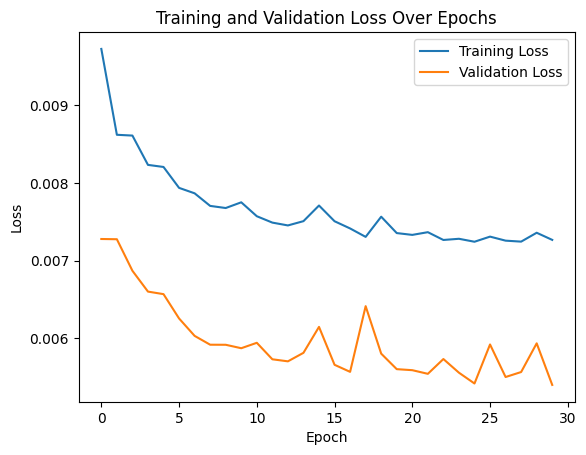

In [10]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label='Training Loss')      
plt.plot(history.history['val_loss'], label='Validation Loss') 

plt.xlabel('Epoch')    
plt.ylabel('Loss')     

plt.legend()

plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


10/10 [==============================] - 0s 2ms/step - loss: 0.0054
Test Loss: 0.005395038519054651


In [12]:
# 예측값 중 가장 큰 확률을 가지는 클래스 선택
predictions = np.argmax(model.predict(X_test), axis=1)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, predictions)

# Print the calculated loss
print(f'Mean Squared Error on Test Set: {mse}')

10/10 [==============================] - 0s 2ms/step
Mean Squared Error on Test Set: 15.67527058050525


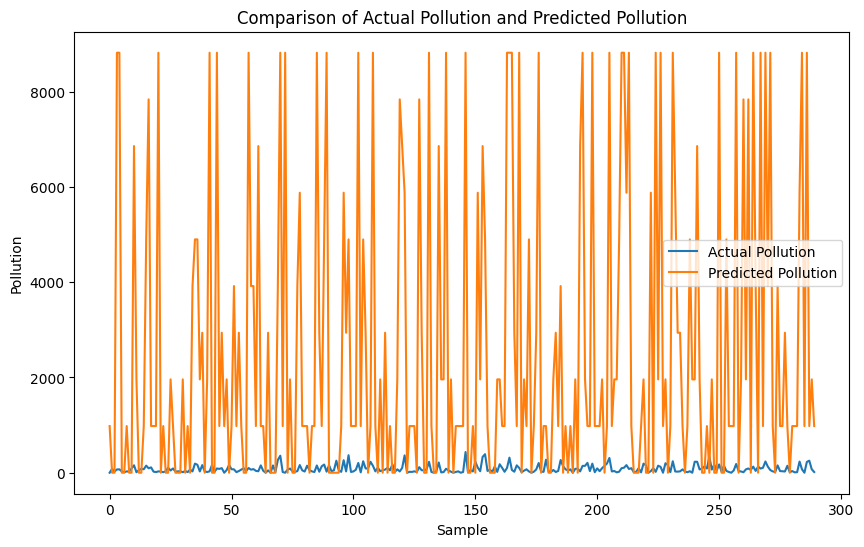

In [13]:
# 역정규화
y_test_inverse = scaler_y.inverse_transform(y_test)
predictions_inverse = scaler_y.inverse_transform(predictions.reshape(-1, 1))

# 예측 결과와 실제 결과 비교를 위한 그래프 생성
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual Pollution')
plt.plot(predictions_inverse, label='Predicted Pollution')
plt.title('Comparison of Actual Pollution and Predicted Pollution')
plt.xlabel('Sample')
plt.ylabel('Pollution')
plt.legend()
plt.show()
